In [1]:
from GA.geneticAlgorithm import GenerationalGA
from GA.parentSelector.parentSelector import RandomParentSelector, LinealOrder, TournamentSelection
from GA.parentSelector.parentSelector import WheelSelection, LinealOrderII
from utils.datamanager import DataManager
from utils.codificication_mlp import Layer, Cromosome, Fitness

import numpy as np
from time import time

Using TensorFlow backend.


In [19]:
from scipy import stats


class ParameterSensibilation(object):
    
    def __init__(self,chrom, cross_validation=False, iters=5, act=True, drop=True,
                 units=True, layers=True, delta=False):
        self.cross_val = cross_validation
        self.iters = iters
        self.act = act
        self.drop = drop
        self.units = units
        self.layers = layers
        self.chrom = chrom
        self.levels = 2
        self.delta = delta
        print("Testing Baseline")
        self.baseline_data = self.test_single(self.chrom)
        
    def compare_with(self, a_chrom):
        fits = self.test_samples([a_chrom])
        
    def start_tests(self):
        all_fits = []
        if self.act:
            all_fits.append(self.activation_test(self.chrom))
        if self.drop:
            all_fits.append(self.dropout_test(self.chrom, self.delta))
        if self.units:
            all_fits.append(self.units_test(self.chrom, self.delta))
        if self.layers:
            all_fits.append(self.layer_test(self.chrom))
        return all_fits
        
    def test_single(self, new_chrom):
        fits = np.ones(5)
        print(new_chrom, end='')
        if self.cross_val:
            fits = new_chrom.cross_val(exclude_first=False)
        else:
            fits = [new_chrom.fitness() for i in range(self.iters)]
        print("Fitness: %0.4f (%0.4f)" % (np.mean(fits), np.std(fits)))
        return fits
    
    
    def test_samples(self, new_chroms):
        for new_chrom in new_chroms:
            fits = self.test_single(new_chrom)
            t_value, p_value = stats.ttest_ind(self.baseline_data, fits)
            print("t = %0.4f, p = %0.4f\n" % (t_value, p_value))
        return fits
        
    
    def activation_test(self, chrom, crossval=True):
        print("\nActivation test:\n")
        new_chroms = []
        all_relu = chrom.self_copy()
        for n in range(len(chrom.layers)):
            new_chrom = chrom.self_copy()
            new_chrom.layers[n].activation = 'relu'
            new_chroms.append(new_chrom)
            all_relu.layers[n].activation = 'relu'
        new_chroms.append(all_relu)
        return self.test_samples(new_chroms)


    def dropout_test(self, chrom, crossval=False, delta=False):

        def get_drop(d, i):
            if i < 0:
                return d - d * (2 ** i)
            else:
                return d + (1 - d) * (0.5 ** (i + 1))

        print("\nDropout test\n")
        new_chroms = [chrom.self_copy() for i in range(len(chrom.layers))]
        if delta:
            new_chroms = [chrom.self_copy() for i in range(2 * self.levels)]
        dropout_zero = chrom.self_copy()
        dropout_02 = chrom.self_copy()
        for n in range(len(chrom.layers)):
            dropout_zero.layers[n].dropout = 0
            dropout_02.layers[n].dropout = 0.2
            if delta:
                for i in range(len(new_chroms)):
                    d = new_chroms[i].layers[n].dropout
                    new_chroms[i].layers[n].dropout = get_drop(d, i - self.levels)
            else:
                new_chroms[n].layers[n].dropout = 0.2
        new_chroms.append(dropout_zero)
        new_chroms.append(dropout_02)
        return self.test_samples(new_chroms)

    
    def layer_test(self, chrom):
        print("\nLayer test\n")
        new_chroms = [chrom.self_copy()]
        for i in range(len(chrom.layers)):
            original_chrom = new_chroms[-1].self_copy()
            new_layers = original_chrom.layers
            new_layers.pop()
            new_chroms.append(Cromosome(new_layers))
        return self.test_samples(new_chroms)


    def units_test(self, chrom, delta=True):
        def get_units(d, i):
            if i < 0:
                return int(d * (1 + i * 0.2))
            else:
                return int(d * (1 + (i + 1) * 0.2))

        print("\nUnits test\n")
        new_chroms = [chrom.self_copy() for i in range(len(chrom.layers))]
        if delta:
            new_chroms = [chrom.self_copy() for i in range(2 * self.levels)]
        
        units_512 = chrom.self_copy()
        for n in range(len(chrom.layers)):
            units_512.layers[n].units = 512
            if delta:
                for i in range(2 * self.levels):
                    d = new_chroms[i].layers[n].units
                    new_chroms[i].layers[n].units = get_units(d, i - self.levels)
            else:
                new_chroms[n].layers[n].units = 512
        new_chroms.append(units_512)
        return self.test_samples(new_chroms)

In [2]:
l = Layer(512, 'relu', 0.2)
l2 = Layer(512, 'relu', 0.2)
benchm = Cromosome([l, l2])

ps = {'random':RandomParentSelector(), 'lineal':LinealOrder(), 'wheel':WheelSelection(), 
      'tournament':TournamentSelection(5)}

# dataset params:
dataset = 'mnist'
classes = []

# genetic algorithm params:
parents_selector_key = 'tournament'
num_parents = 0.3
generations = 3
population = 5
train_time = 60
maximize_fit = False
stat_val=False
folder = "../delete"
save_progress = False
p = ps[parents_selector_key]



# Fitness params
epochs = 1
batch_size = 128
maximize_fit = True
verbose = 1
redu_plat = False
early_stop = True

c  = Cromosome([Layer(830, 'prelu',0.654), Layer(782, 'tanh', 0.166), Layer(28, 'elu', 0.062)])


# Load data
dm = DataManager(dataset, clases=classes)
data = dm.load_data()
fitness = Fitness.get_instance()
fitness.set_params(data, batch_size=batch_size, verbose=verbose, reduce_plateau=redu_plat, 
                   epochs=epochs, early_stop=early_stop)
p = ps[parents_selector_key]

(48000, 28, 28, 1) train samples
(12000, 28, 28, 1) validation samples
(10000, 28, 28, 1) test samples


In [21]:
c  = Cromosome([Layer(830, 'prelu',0.654), Layer(782, 'tanh', 0.166), Layer(28, 'elu', 0.062)])
c0 = Cromosome([Layer(830, 'prelu', 0.654)])
c1 = Cromosome([Layer(int(830*0.8), 'prelu', 0.654)])
c2 = Cromosome([Layer(int(830*0.6), 'prelu', 0.654)])
c4 = Cromosome([Layer(830, 'relu', 0.654)])
c6 = Cromosome([Layer(830, 'prelu', 0.2)])





ps = ParameterSensibilation(c, drop=True, layers=False, act=True, iters=5, delta=True)
all_fits = []
to_compare = [c0, c1, c2, c3, c4, c5]
for c_ in to_compare:
    all_fits.append(ps.compare_with(c_))

Testing Baseline
0 - U:830|A:prelu|D:0.654 
1 - U:782|A:tanh|D:0.166 
2 - U:28|A:elu|D:0.062 
Fitness: 0.9840 (0.0007)
0 - U:830|A:prelu|D:0.654 
Fitness: 0.9841 (0.0002)
t = -0.4725, p = 0.6492

0 - U:664|A:prelu|D:0.654 
Fitness: 0.9838 (0.0005)
t = 0.3070, p = 0.7667

0 - U:498|A:prelu|D:0.654 
Fitness: 0.9828 (0.0008)
t = 2.2600, p = 0.0537

0 - U:996|A:prelu|D:0.654 
Fitness: 0.9840 (0.0004)
t = -0.0426, p = 0.9670

0 - U:830|A:relu|D:0.654 
Fitness: 0.9841 (0.0004)
t = -0.3266, p = 0.7524

0 - U:830|A:prelu|D:0.000 
Fitness: 0.9845 (0.0011)
t = -0.7756, p = 0.4603



In [22]:
ps.compare_with(c6)

0 - U:830|A:prelu|D:0.200 
Fitness: 0.9826 (0.0010)
t = 2.2640, p = 0.0534



Genetic algorithm params
Number of generations: 3
Population size: 5
num parents: 1
offspring size: 4

Creating Initial population

Start evolution process...

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 906)               711210    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 906)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 906)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 687)        

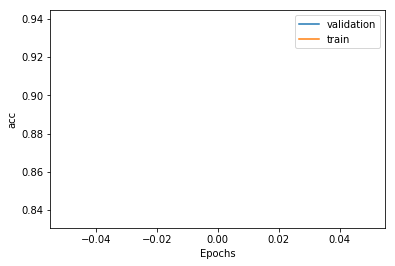

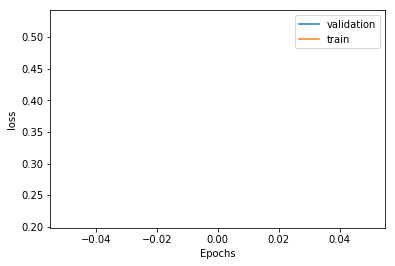

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________
Train on 48000 samples, validate on 12000 samples
Epoch 1/1
48000/48000 [==============================] - 1s 18us/step - loss: 0.7400 - acc: 0.8224 - val_loss: 0.4063 - val_acc: 0.8952
Val loss: 0.4063,Val acc: 0.8952


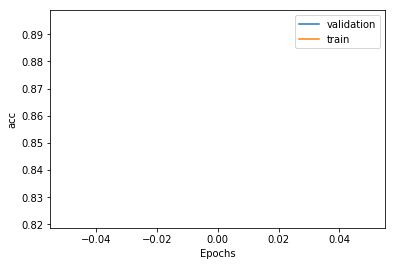

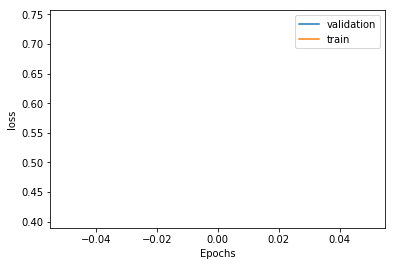

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 494)               387790    
_________________________________________________________________
dropout_1 (Dropout)          (None, 494)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 3960      
_________________________________________________________________
dropout_2 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                90        
Total para

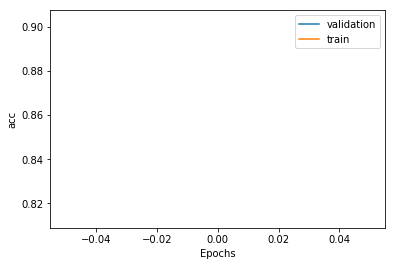

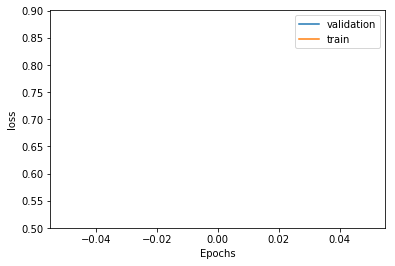

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 562)               441170    
_________________________________________________________________
dropout_1 (Dropout)          (None, 562)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5630      
Total params: 446,800
Trainable params: 446,800
Non-trainable params: 0
_________________________________________________________________
Train on 48000 samples, validate on 12000 samples
Epoch 1/1
48000/48000 [==============================] - 1s 27us/step - loss: 0.4535 -

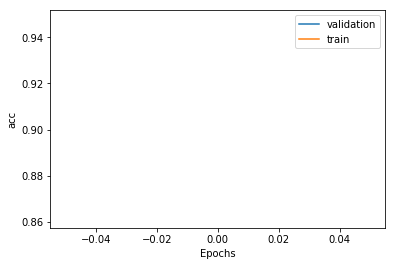

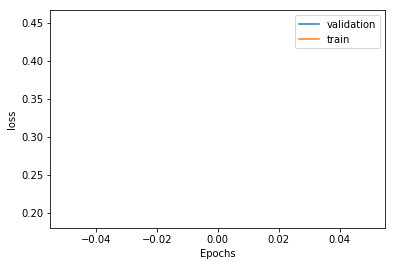

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 588)               461580    
_________________________________________________________________
dropout_1 (Dropout)          (None, 588)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 314)               184946    
_________________________________________________________________
dropout_2 (Dropout)          (None, 314)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 511)               160965    
__________

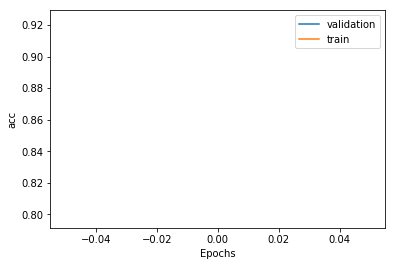

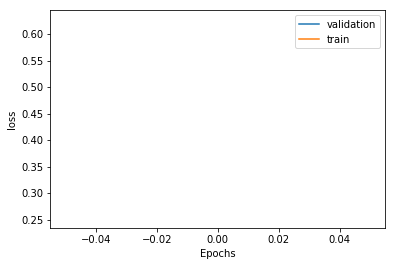

 -------   Actualizing history  0 -------
0.9474166666666667
0.9391666666666667
0.9230833333333334
0.903
0.8951666666666667
1) best fit: 0.947 in batch time: 0.27 mins
Current winner:
0 - U:562|A:relu|D:0.718 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 562)               441170    
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 562)               562       
_________________________________________________________________
dropout_1 (Dropout)          (None, 562)               0         
_______________________________________________________________

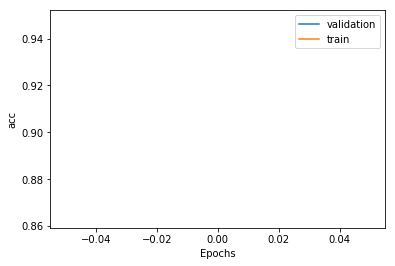

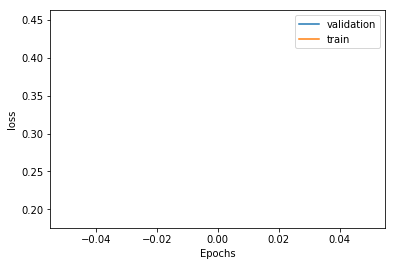

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1013)              795205    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1013)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                10140     
Total params: 805,345
Trainable params: 805,345
Non-trainable params: 0
_________________________________________________________________
Train on 48000 samples, validate on 12000 samples
Epoch 1/1
48000/48000 [==============================] - 2s 33us/step - loss: 0.3938 -

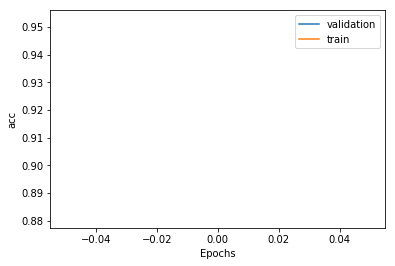

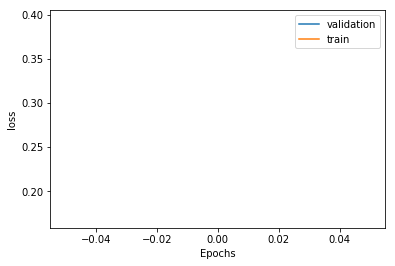

 -------   Actualizing history  1 -------
0.9524166666666667
0.9478333333333333
0.9474166666666667
0.9474166666666667
0.8951666666666667
2) best fit: 0.952 in batch time: 0.35 mins
Current winner:
0 - U:1013|A:relu|D:0.718 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1013)              795205    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1013)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                10140     
Total params: 805,345
Trainable params: 805,345
N

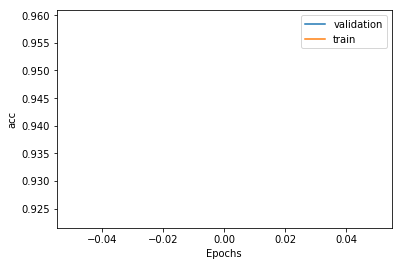

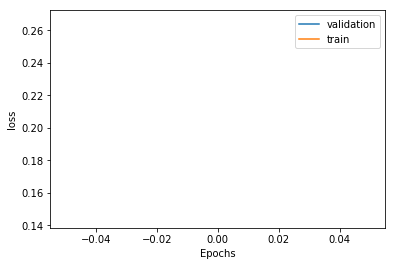

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 801)               628785    
_________________________________________________________________
dropout_1 (Dropout)          (None, 801)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                8020      
Total params: 636,805
Trainable params: 636,805
Non-trainable params: 0
_________________________________________________________________
Train on 48000 samples, validate on 12000 samples
Epoch 1/1
48000/48000 [==============================] - 1s 30us/step - loss: 0.4078 -

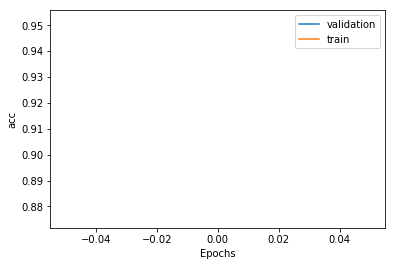

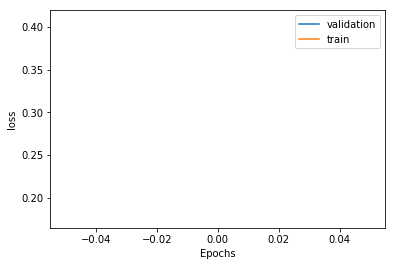

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 582)               456870    
_________________________________________________________________
dropout_1 (Dropout)          (None, 582)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                5830      
Total params: 462,700
Trainable params: 462,700
Non-trainable params: 0
_________________________________________________________________
Train on 48000 samples, validate on 12000 samples
Epoch 1/1
48000/48000 [==============================] - 1s 28us/step - loss: 0.4537 -

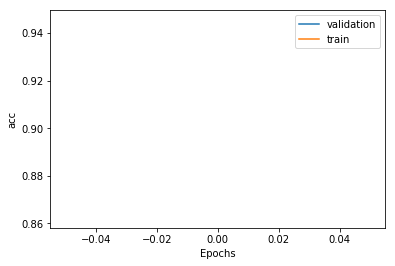

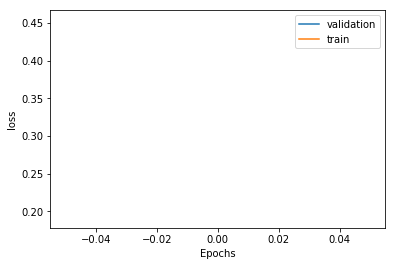

 -------   Actualizing history  2 -------
0.9590833333333333
0.9524166666666667
0.9524166666666667
0.9519166666666666
0.9454166666666667
3) best fit: 0.959 in batch time: 0.46 mins
Current winner:
0 - U:1013|A:relu|D:0.032 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1013)              795205    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1013)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                10140     
Total params: 805,345
Trainable params: 805,345
N

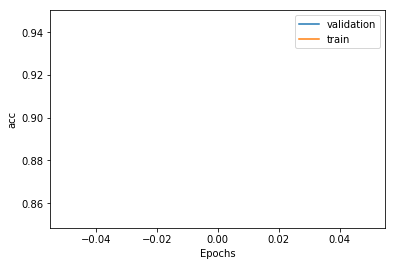

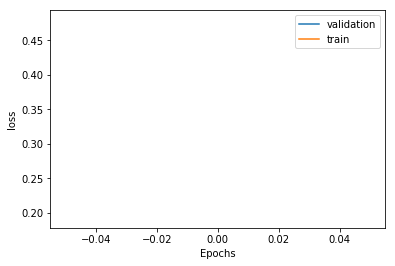

 -------   Actualizing history  3 -------
0.9590833333333333
0.9590833333333333
0.9590833333333333
0.9455833333333333
0.8951666666666667
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1013)              795205    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1013)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                10140     
Total params: 805,345
Trainable params: 805,345
Non-trainable params: 0
_________________________________________________________________

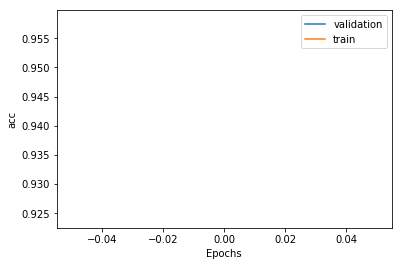

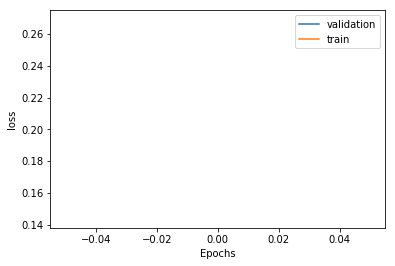

Best Gen -> 
0 - U:1013|A:relu|D:0.032 

With Fitness (val): 0.9591 and (test): 0.9556


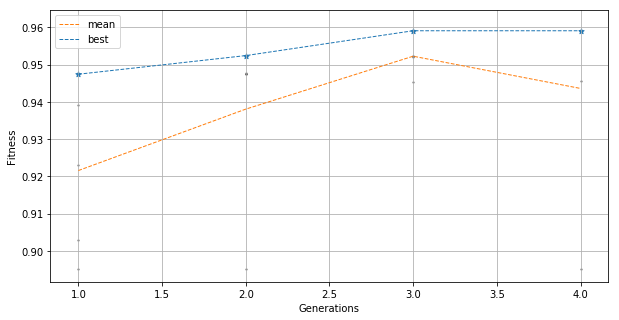

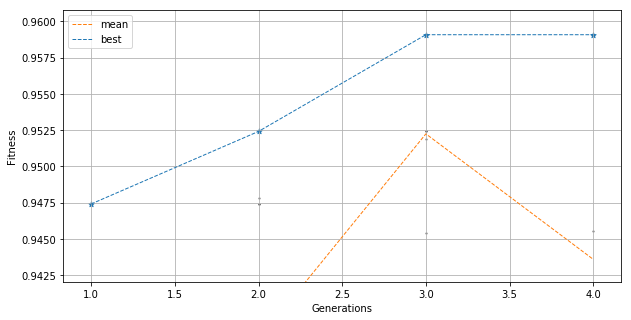

Total elapsed time: 32.456
Total training time: 32.088


In [3]:
ti_all = time()
generational = GenerationalGA(num_parents=num_parents, chromosome=c, parent_selector=p, generations=generations,
                              num_population=population, maximize_fitness=maximize_fit, 
                              training_hours=train_time, folder=folder, statistical_validation=stat_val,
                             save_progress=save_progress)
winner, best_fit, ranking = generational.evolve()
print("Total elapsed time: %0.3f" % (time() - ti_all))
print("Total training time: %0.3f" % fitness.time)

In [4]:
print(generational.history)

[[0.94741667 0.95241667 0.95908333 0.95908333]
 [0.93916667 0.94783333 0.95241667 0.95908333]
 [0.92308333 0.94741667 0.95241667 0.95908333]
 [0.903      0.94741667 0.95191667 0.94558333]
 [0.89516667 0.89516667 0.94541667 0.89516667]]


In [11]:
h = generational.history_fitness
print(len(h.keys()))
win, best_fit = None, 0
for k,v in h.items():
    if v > best_fit:
        best_fit = v
        win = k
print(best_fit)
print(win)

19
0.9635833333333333
0 - U:773|A:prelu|D:0.440 
1 - U:562|A:tanh|D:0.281 



In [14]:
print(generational.best_fit_history)

{}


In [6]:
winner = Cromosome([Layer(830, 'prelu',0.654), Layer(782, 'tanh', 0.166), Layer(28, 'elu', 0.062)])
benchm = Cromosome([Layer(512, 'relu', 0.2), Layer(512, 'relu', 0.2)])

In [14]:
ps = ParameterSensibilation(Cromosome([Layer(830, 'prelu', 0.654)]), 
                            drop=True, layers=False, act=True, iters=10, delta=True)
fits = ps.start_tests()

Testing Baseline
0 - U:830|A:prelu|D:0.654 
Fitness: 0.9840 (0.0006)

Activation test:

0 - U:830|A:relu|D:0.654 
Fitness: 0.9841 (0.0007)
t = -0.1443, p = 0.8888

0 - U:830|A:relu|D:0.654 
Fitness: 0.9835 (0.0005)
t = 1.2805, p = 0.2362


Dropout test

0 - U:830|A:prelu|D:0.200 
Fitness: 0.9831 (0.0003)
t = 2.7809, p = 0.0239

0 - U:830|A:prelu|D:0.000 
Fitness: 0.9842 (0.0005)
t = -0.4491, p = 0.6653

0 - U:830|A:prelu|D:0.200 
Fitness: 0.9827 (0.0008)
t = 2.6370, p = 0.0299


Units test

0 - U:498|A:prelu|D:0.654 
Fitness: 0.9836 (0.0003)
t = 1.1070, p = 0.3005

0 - U:664|A:prelu|D:0.654 
Fitness: 0.9835 (0.0006)
t = 1.1767, p = 0.2731

0 - U:996|A:prelu|D:0.654 
Fitness: 0.9845 (0.0003)
t = -1.2430, p = 0.2490

0 - U:1162|A:prelu|D:0.654 
Fitness: 0.9843 (0.0004)
t = -0.8619, p = 0.4139

0 - U:512|A:prelu|D:0.654 
Fitness: 0.9836 (0.0004)
t = 1.0839, p = 0.3100



In [11]:
ps = ParameterSensibilation(winner, act=False, drop=False, layers=True, units=False, iters=5)
ps.start_tests()

Testing Baseline
0 - U:830|A:prelu|D:0.654 
1 - U:782|A:tanh|D:0.166 
2 - U:28|A:elu|D:0.062 
Fitness: 0.9838 (0.0006)

Units test

0 - U:512|A:prelu|D:0.654 
1 - U:782|A:tanh|D:0.166 
2 - U:28|A:elu|D:0.062 
Fitness: 0.9826 (0.0007)
t = 2.4607, p = 0.0393

0 - U:830|A:prelu|D:0.654 
1 - U:512|A:tanh|D:0.166 
2 - U:28|A:elu|D:0.062 
Fitness: 0.9842 (0.0007)
t = -0.9141, p = 0.3874

0 - U:830|A:prelu|D:0.654 
1 - U:782|A:tanh|D:0.166 
2 - U:512|A:elu|D:0.062 
Fitness: 0.9845 (0.0004)
t = -1.9158, p = 0.0917

0 - U:512|A:prelu|D:0.654 
1 - U:512|A:tanh|D:0.166 
2 - U:512|A:elu|D:0.062 
Fitness: 0.9828 (0.0007)
t = 1.9620, p = 0.0854



In [ ]:
fitness.calc_mean(winner)

In [ ]:
fitness.calc_mean(benchm)

In [3]:
1500/3600

0.4166666666666667